# This notebook will show how to use the ROSE framework to run two active learning algorithms in parallel and select the best one based on a metric.

In [ ]:
import os
import sys

from rose.al.selector import AlgorithmSelector
from rose.metrics import MEAN_SQUARED_ERROR_MSE

from radical.asyncflow import WorkflowEngine
from radical.asyncflow import RadicalExecutionBackend

Let us prepare our execution engine using a local resource (user computer). We will ask for 30 minutes as this example will run fast.

In [ ]:
engine = await RadicalExecutionBackend({'resource': 'local.localhost'})
asyncflow = await WorkflowEngine.create(engine)
selector = AlgorithmSelector(asyncflow)

code_path = f'{sys.executable} {os.getcwd()}'

Resource Engine started successfully

Task 'simulation' ready to submit; resolved dependencies: []
Task 'simulation' ready to submit; resolved dependencies: []
submitting ['simulation', 'simulation'] for execution
task.000001 is DONE
task.000000 is DONE
Task 'training' ready to submit; resolved dependencies: ['simulation']
Task 'training' ready to submit; resolved dependencies: ['simulation']
submitting ['training', 'training'] for execution
task.000003 is DONE
task.000002 is DONE
Task 'active_learn_2' ready to submit; resolved dependencies: ['simulation', 'training']
Task 'active_learn_1' ready to submit; resolved dependencies: ['simulation', 'training']
submitting ['active_learn_2', 'active_learn_1'] for execution
task.000005 is DONE
task.000004 is DONE
Task 'check_mse' ready to submit; resolved dependencies: ['active_learn_1']
Task 'check_mse' ready to submit; resolved dependencies: ['active_learn_2']
submitting ['check_mse', 'check_mse'] for execution
task.000006 is DONE
Task 'simu

We will define our active learning workflow components like our previous tutorials. Please note that, unlike the previous tutorials, we defined **two** active learning tasks (`algo1` and `algo2`). ROSE will select the best based on the number of iterations and the final selected metric.

In [ ]:
# Define and register the simulation task
@selector.simulation_task
async def simulation(*args):
    f'{code_path}/sim.py'

# Define and register the training task
@selector.training_task
async def training(*args):
    f'{code_path}/train.py'

# Define and register Multiple AL tasks
@selector.active_learn_task(name='algo_1')
async def active_learn_1(*args):
    f'{code_path}/active_1.py'

@selector.active_learn_task(name='algo_2')
async def active_learn_2(*args):
    f'{code_path}/active_2.py'

# Defining the stop criterion with a metric (MSE in this case)
@selector.as_stop_criterion(metric_name=MEAN_SQUARED_ERROR_MSE, threshold=0.01)
async def check_mse(*args):
    f'{code_path}/check_mse.py'

Let us invoke our workflow and instruct ROSE to select one of both algorithms.

In [ ]:
# Start the learning process
await selector.start(max_iter=4)
await selector.shutdown()

Pipeline-algo_1 is submitted for execution
Registered task 'simulation' and id of 000000 with dependencies: []
Pipeline-algo_2 is submitted for execution
Registered task 'simulation' and id of 000001 with dependencies: []
Registered task 'training' and id of 000002 with dependencies: ['simulation']
[Pipeline: active_learn_1] Starting Iteration-0
Registered task 'training' and id of 000003 with dependencies: ['simulation']
[Pipeline: active_learn_2] Starting Iteration-0
Registered task 'active_learn_1' and id of 000004 with dependencies: ['simulation', 'training']
Registered task 'active_learn_2' and id of 000005 with dependencies: ['simulation', 'training']
Registered task 'check_mse' and id of 000006 with dependencies: ['active_learn_1']
Registered task 'check_mse' and id of 000007 with dependencies: ['active_learn_2']
stop criterion metric: mean_squared_error_mse is not met yet (0.031850318097452895).
Registered task 'simulation' and id of 000008 with dependencies: ['active_learn_1']

Once the execution is done, we can plot the results and of each algorithm as follows:

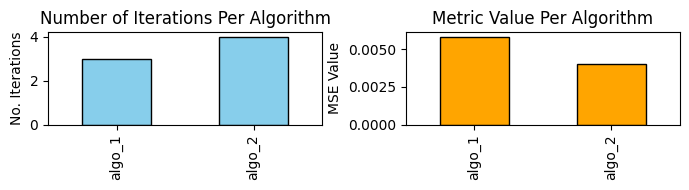

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
results = selector.algorithm_results

# Convert to DataFrame
df = pd.DataFrame(results).T  # Transpose to have algorithms as index

# Create a figure with two subplots: one for iterations and one for last_result
fig, ax = plt.subplots(1, 2, figsize=(7, 2))

# Plot iterations
df['iterations'].plot(kind='bar', ax=ax[0], color='skyblue', title='Number of Iterations Per Algorithm', edgecolor='black')
ax[0].set_ylabel('No. Iterations')

# Plot last_result
df['last_result'].plot(kind='bar', ax=ax[1], color='orange', title='Metric Value Per Algorithm', edgecolor='black')
ax[1].set_ylabel('MSE Value')

# Show plot
plt.tight_layout()
plt.show()

### What do the above plots tell us?

The **Algorithm Selector** evaluates two different active learning algorithms, `algo_1` and `algo_2`, using the same input data. The left plot shows the number of iterations each algorithm required to reach convergence, while the right plot compares their Mean Squared Error (MSE) performance.

From the results, we can observe that algo_2 required more iterations to converge compared to algo_1, indicating a potentially longer training time. However, when analyzing the MSE values, algo_2 achieved a lower error, suggesting better predictive performance. This trade-off between convergence speed and accuracy is an important consideration when selecting an active learning strategy. In practical applications, users may prioritize either efficiency (fewer iterations) or model accuracy (lower MSE) depending on their specific requirements.

More importantly is that all of the work above was done in an **embarrassingly parallel** approach, and **effortlessly**.